# Word2Vec (Google) : Pré-entraînement sur un corpus en français. 

## Modèles  de Word Embeddings 

In [1]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Télécharger les données nécessaires
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Charger les données
file_path = "../tweets_labelled.csv"
df = pd.read_csv(file_path)

### Nettoyage des données

In [4]:
# Supprimer les lien et les emojis
def remove_links(text):
    text = re.sub(r"http\S+", "", text)  # Supprimer les liens
    text = text.encode('ascii', 'ignore').decode('ascii') # supprimer les emojis
    # text = text.lower()  # Convertir en minuscules
    return text

df['cleaned_text'] = df['Texte'].astype(str).apply(remove_links)

In [5]:
# Mettre les mentions dans une autre colonne et les supprimer du texte
def get_mentions(text):
    mentions = re.findall(r"@\S+", text)
    return mentions

def remove_mentions(text):
    text = re.sub(r"@\S+", "", text)
    return text

df['mentions'] = df['cleaned_text'].apply(get_mentions)
df['cleaned_text'] = df['cleaned_text'].apply(remove_mentions)

In [6]:
# visualiser uniquement les caractères spéciaux
def special_characters(text):
    text = re.sub(r"[a-zA-Z\s]", "", text)  # Supprimer les caractères spéciaux
    return text

# afficher la totalité des caractères spéciaux
# print(df['cleaned_text'].apply(special_characters).sum())

In [7]:
# afficher uniquement les mentions
def mentions(text):
    text = re.findall(r"@\S+", text)  # Trouver les mentions
    return text

# afficher les mentions
print(df['cleaned_text'].apply(mentions).sum())

[]


In [8]:
# Supprimer les caractères spéciaux
def remove_special_characters(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Supprimer les caractères spéciaux
    return text

df['cleaned_text'] = df['cleaned_text'].apply(remove_special_characters)

In [9]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0               0
Index                   48
Texte                   48
Media                 1611
Interaction             54
Sujet                   58
Données manquantes     602
A supprimer            101
cleaned_text             0
mentions                 0
dtype: int64


In [10]:
# Supprimer la colonne Media
df.drop(columns=['Media'], inplace=True)

In [11]:
# Si une ligne a un index manquant, supprimez-le
df.dropna(subset=['Index'], inplace=True)


In [12]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0              0
Index                   0
Texte                   0
Interaction             6
Sujet                  10
Données manquantes    602
A supprimer           101
cleaned_text            0
mentions                0
dtype: int64


In [13]:
# Supprimer les mots inutiles
stop_words = set(stopwords.words('french'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(text)


df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

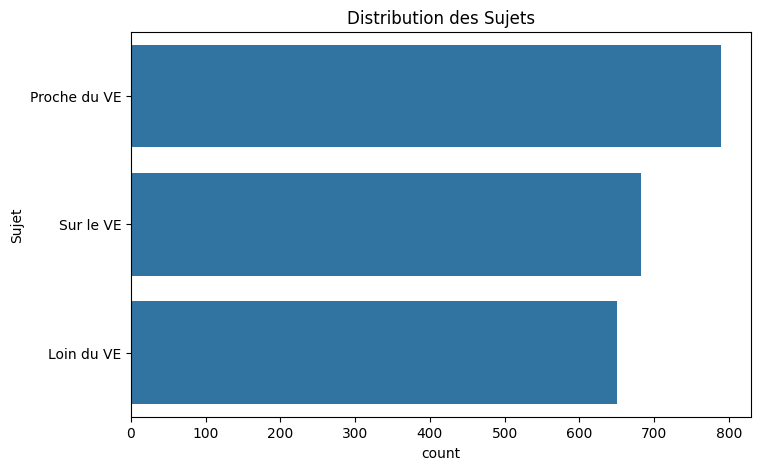

Sujet
Proche du VE    790
Sur le VE       682
Loin du VE      650
Name: count, dtype: int64

In [14]:
# Analyse des catégories (distribution des sujets)
plt.figure(figsize=(8, 5))
sns.countplot(y='Sujet', data=df, order=df['Sujet'].value_counts().index)
plt.title("Distribution des Sujets")
plt.show()

# Analyse des catégories (distribution des sujets) par un tableau
df['Sujet'].value_counts()


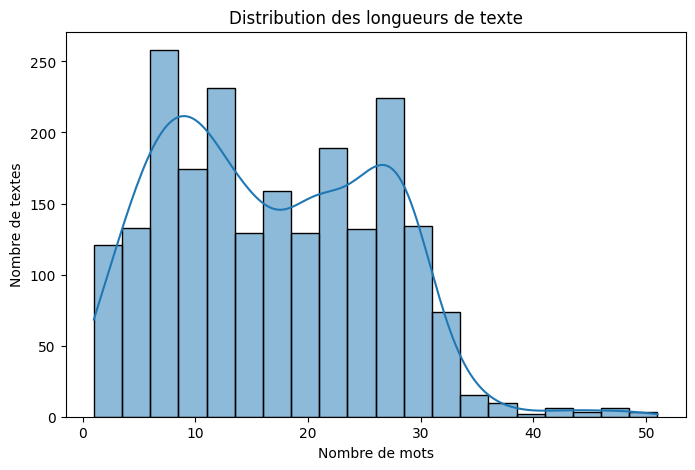

In [15]:
# Analyse des longueurs de texte
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title("Distribution des longueurs de texte")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de textes")
plt.show()

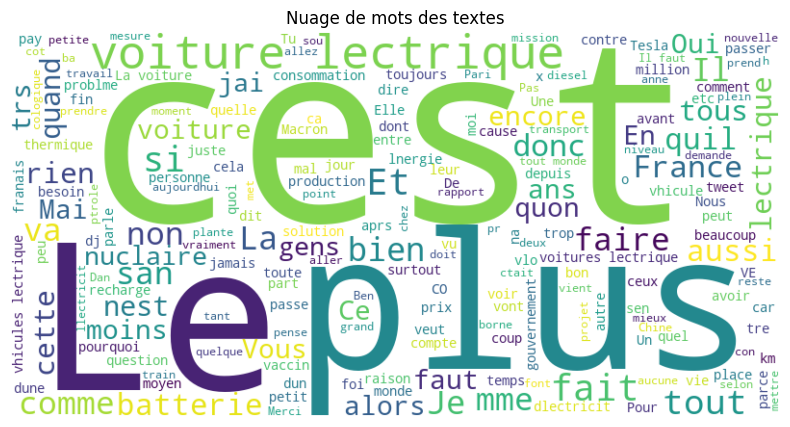

In [16]:
# Nuage de mots (WordCloud)
all_text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des textes")
plt.show()

In [17]:
# Fréquences des mots
from collections import Counter

all_words = " ".join(df['cleaned_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)

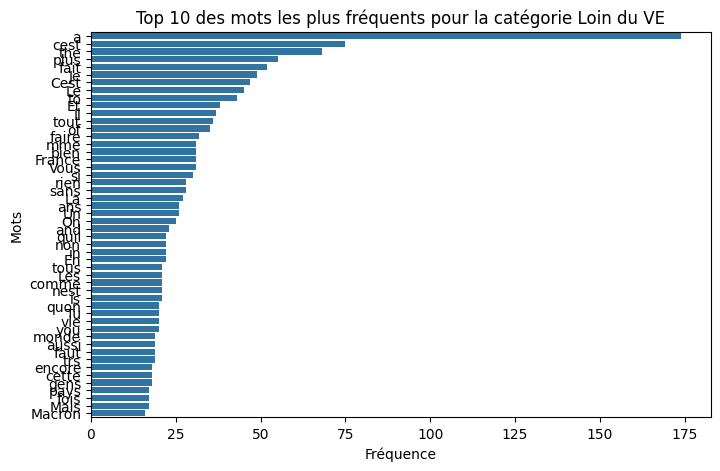

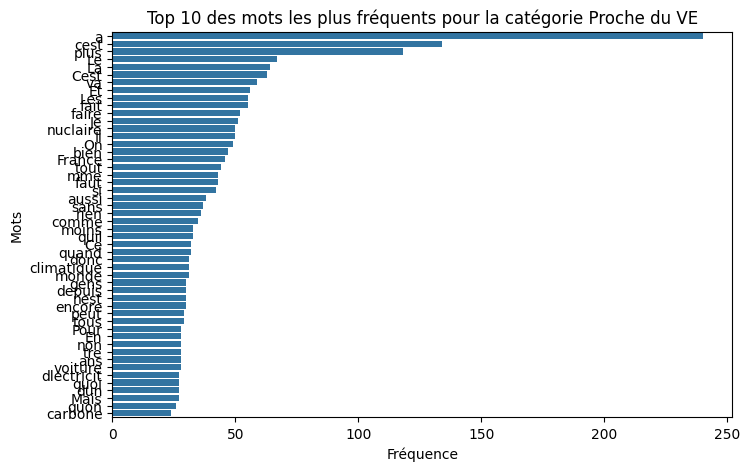

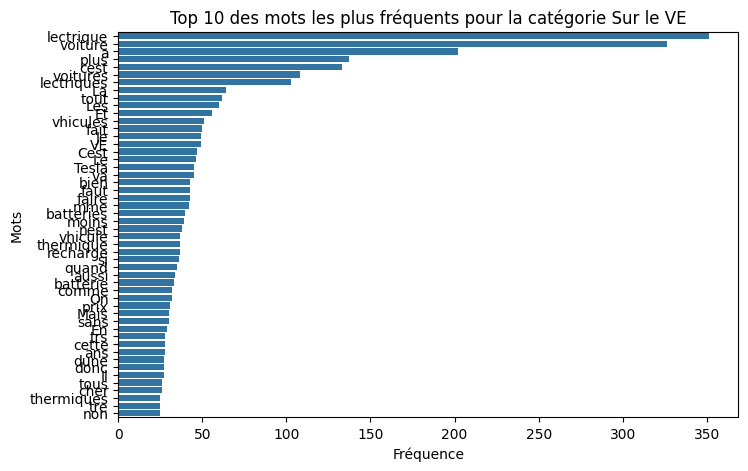

In [18]:
# Afficher les mots les plus fréquents par catégorie
categories = df['Sujet'].unique()

for category in categories:
    text = " ".join(df[df['Sujet'] == category]['cleaned_text']).split()
    word_freq = Counter(text)
    common_words = word_freq.most_common(50)

    if common_words:  # Check if common_words is not empty
        words, counts = zip(*common_words)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f"Top 10 des mots les plus fréquents pour la catégorie {category}")
        plt.xlabel("Fréquence")
        plt.ylabel("Mots")
        plt.show()

In [19]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Tokeniser les textes nettoyés
df['tokens'] = df['cleaned_text'].apply(lambda x: word_tokenize(x.lower()))

# Entraîner le modèle Word2Vec
sentences = df['tokens'].tolist()  # Obtenir toutes les phrases tokenisées
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Mots clés pour détecter les tweets sur les voitures électriques
keywords = ["lectricit", "voiture", "voitures", "vhicules", "vhicule", "tesla", "recharge", "batterie", "batteries", "thermique", "recharge", "thermiques", "hybride", "hybrides", "pollution", "polluer", "polluants", "polluante", "polluantes", "bornes"]

# Fonction pour calculer la similarité moyenne entre les mots d'un tweet et les mots-clés
def calculate_similarity(tweet_tokens, model, keywords):
    similarities = []
    for word in tweet_tokens:
        if word in model.wv:  # Vérifiez si le mot est dans le vocabulaire du modèle
            word_similarities = [model.wv.similarity(word, keyword) for keyword in keywords if keyword in model.wv]
            if word_similarities:
                similarities.append(max(word_similarities))
    return np.mean(similarities) if similarities else 0

# Calculer la similarité pour chaque tweet
df['similarity'] = df['tokens'].apply(lambda x: calculate_similarity(x, model, keywords))

In [28]:
# Filtrer les tweets pertinents (similarité > seuil, par exemple 0.5)
relevant_tweets = df[df['similarity'] > 0.6]

# Afficher les tweets pertinents
print(relevant_tweets[['Texte', 'similarity']])

                                                  Texte  similarity
2     SAbdelhamid :\n"@FloPortelli @le_Parisien Ce q...    0.625196
3     eve_thefirst :\n"@SAbdelhamid @FloPortelli @le...    0.628531
4     ChipeauxMylene :\n"@eve_thefirst @SAbdelhamid ...    0.691376
8     WestRiseAgain :\n"@Mediavenir Les autorités fo...    0.691972
14    Alex_Car12 :\n"@GDarmanin Alors que les accide...    0.606648
...                                                 ...         ...
2164  Emilien57686974 :\n"@laydgeur Il me semble que...    0.639464
2165     laydgeur :\n"@Emilien57686974 Je vois pas non"    0.742951
2166  BFMTV :\n"Coupures de courant: comment savoir ...    0.683078
2167  moreau_lizzie :\n"@BFMTV Vraie question : nos ...    0.642172
2171  fredbourget :\n"Comme si ce cave-là était prêt...    0.722698

[757 rows x 2 columns]


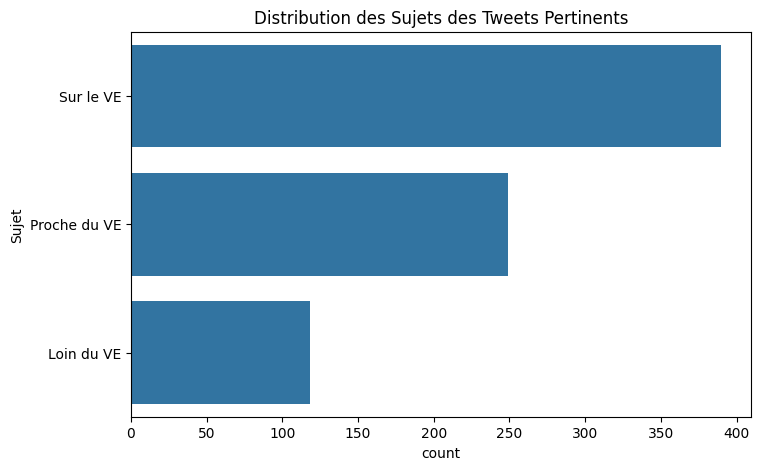

In [29]:
# verrifier si les tweets pertinents sont bien classés
plt.figure(figsize=(8, 5))
sns.countplot(y='Sujet', data=relevant_tweets, order=relevant_tweets['Sujet'].value_counts().index)
plt.title("Distribution des Sujets des Tweets Pertinents")
plt.show()

In [30]:
# verrifier si les tweets pertinents sont bien classés par un tableau
print(relevant_tweets['Sujet'].value_counts())

Sujet
Sur le VE       390
Proche du VE    249
Loin du VE      118
Name: count, dtype: int64


In [31]:
# Calculer le pourcentage de tweets pertinents par catégorie
total_tweets = df['Sujet'].value_counts()
relevant_tweets_count = relevant_tweets['Sujet'].value_counts()
percentage_relevant_tweets = (relevant_tweets_count / total_tweets) * 100

print(percentage_relevant_tweets)

Sujet
Loin du VE      18.153846
Proche du VE    31.518987
Sur le VE       57.184751
Name: count, dtype: float64
